# Image caption generator

## Part 1 - seq2seq auto encoder

In [1]:
from fastai.text import *
import pandas as pd
from pathlib import Path

In [79]:
gpu = torch.device('cuda:0')

In [2]:
PATH = Path('data/')
PATH.mkdir(exist_ok=True)

In [3]:
seq_PATH = PATH/'seq2deq_model'
seq_PATH.mkdir(exist_ok=True)

In [4]:
captions_and_links_valid = pd.read_csv("Validation_GCC-1.1.0-Validation.tsv", sep="\t",header=None)
captions_and_links_train = pd.read_csv("Train_GCC-training.tsv", sep="\t",header=None)

In [5]:
len(captions_and_links_valid), len(captions_and_links_train)

(15840, 3318333)

In [6]:
captions_and_links_valid.head()

,0,1
0,author : a life in photography -- in pictures,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...
1,an angler fishes river on a snowy day .,http://www.standard.net/image/2015/02/04/800x_...
2,photograph of the sign being repaired by brave...,http://indianapolis-photos.funcityfinder.com/f...
3,the player staring intently at a computer scre...,http://www.abc.net.au/news/image/9066492-3x2-7...
4,globes : the green 3d person carrying in hands...,https://www.featurepics.com/StockImage/2009031...


In [7]:
captions_valid = captions_and_links_valid[0].values
captions_train = captions_and_links_train[0].values

In [8]:
len(captions_train), len(captions_valid)

(3318333, 15840)

### Tokenization

In [9]:
tokenizer = Tokenizer()

In [10]:
tokens_captions_valid = tokenizer.process_all(captions_valid)

In [11]:
tokens_captions_train = tokenizer.process_all(captions_train)

**Let's make sure everything went right:**

In [12]:
print(captions_train[777], ' '.join(tokens_captions_train[777]))

people click into their skis . people click into their skis .


### Length of captions
#### Average length of captions

In [13]:
np.mean([len(c) for c in tokens_captions_valid])

10.415467171717172

In [14]:
np.mean([len(c) for c in tokens_captions_train])

10.322056888202601

#### Discard captions that are too long

In [15]:
tokens_captions_valid = np.array(tokens_captions_valid)[np.array([len(c) < 30 for c in tokens_captions_valid])]

In [16]:
np.max([len(c) for c in tokens_captions_valid])

29

In [17]:
tokens_captions_train = np.array(tokens_captions_train)[np.array([len(c) < 30 for c in tokens_captions_train])]

In [18]:
np.max([len(c) for c in tokens_captions_train])

29

In [19]:
pickle.dump((tokens_captions_valid), (seq_PATH/'tok_cap_v.pkl').open('wb'))

In [20]:
pickle.dump((tokens_captions_train), (seq_PATH/'tok_cap_t.pkl').open('wb'))

In [21]:
tokens_captions_valid = pickle.load((seq_PATH/'tok_cap_v.pkl').open('rb'))

In [22]:
tokens_captions_train = pickle.load((seq_PATH/'tok_cap_t.pkl').open('rb'))

In [23]:
print(len(tokens_captions_train), len(tokens_captions_valid))

3302516 15764


### Numericalization

In [24]:
vocab = Vocab.create(tokens_captions_train, max_vocab=50000, min_freq=2)

**Let's quickly test this:**

In [25]:
idx = 12575

In [26]:
test_caption = tokens_captions_valid[idx]
print(' '.join(w for w in test_caption))

actor attending the world premiere of crime fiction film


In [27]:
test_caption_num = vocab.numericalize(test_caption)
print(test_caption_num)

[31, 1841, 8, 108, 43, 11, 2274, 1018, 76]


In [28]:
print(vocab.textify(test_caption_num))

actor attending the world premiere of crime fiction film


In [29]:
tokens_captions_valid[0]

['author', ':', 'a', 'life', 'in', 'photography', '--', 'in', 'pictures']

In [30]:
def numericalize_tokens(tok):
    return np.array([vocab.numericalize(q) + [1] for q in tok])

In [31]:
captions_numericalized_valid = numericalize_tokens(tokens_captions_valid)

In [32]:
captions_numericalized_train = numericalize_tokens(tokens_captions_train)

Test it:

In [33]:
vocab.textify(captions_numericalized_train[1256339])

'a vector illustration of a motorcycle contrasted against a bicycle . xxpad'

### Word vectors

In [34]:
#! pip install git+https://github.com/facebookresearch/fastText.git

In [35]:
import fastText as ft

In [36]:
en_vecs = ft.load_model(str(seq_PATH/'wiki.en.bin'))

In [37]:
vec_dict = {w : en_vecs.get_word_vector(w) for w in en_vecs.get_words()}

In [38]:
pickle.dump(vec_dict, open(seq_PATH/'vec_dict.pkl', 'wb'))

In [39]:
vec_dict = pickle.load(open(seq_PATH/'vec_dict.pkl','rb'))

**Let's take a look at the most frequent words from fastText:**

In [40]:
ft_words = en_vecs.get_words(include_freq=True)

In [41]:
ft_word_dict = {k:v for k,v in zip(*ft_words)}

In [42]:
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

10 most frequent words:

In [43]:
ft_words[-10:]

[')', "'", 'and', 'in', '-', 'of', '</s>', 'the', '.', ',']

**Mean and stdv of the word vectors:**

In [44]:
vecs = np.stack(list(vec_dict.values()))

In [45]:
vecs.mean(), vecs.std()

(0.0075652334, 0.29283327)

### Dataset

In [46]:
def A(*a):
    """convert iterable object into numpy array"""
    return np.array(a[0]) if len(a)==1 else [np.array(o) for o in a]

In [47]:
class Caption2CaptionDataset(Dataset):
    def __init__(self, x):
        self.x = x
    def __getitem__(self, idx):
        return A(self.x[idx], self.x[idx])
    def __len__(self):
        return len(self.x)

In [48]:
trn_ds = Caption2CaptionDataset(captions_numericalized_train)

In [49]:
val_ds = Caption2CaptionDataset(captions_numericalized_valid)

In [50]:
len(trn_ds), len(val_ds)

(3302516, 15764)

In [51]:
vocab.textify(trn_ds[0][0])

'a very typical bus station xxpad'

### Dataloader

In [52]:
bs = 125

In [53]:
val_sampler = SortSampler(captions_numericalized_valid, key=lambda x:len(captions_numericalized_valid[x]))

In [54]:
trn_sampler = SortishSampler(captions_numericalized_train, key=lambda x: len(captions_numericalized_train[x]), bs=bs)

Since we want to fully utilize the GPUs capabilities, we train in batches. The length of a minibatch tensor is set by the sequence length of the longest question in that batch. The other questions are padded. To save time and memory, we want to avoid very long and very short questions in one batch because that would mean lot's of padding. For the validation set we simply sort the questions. For training we use the `SortishSampler` which groups *longer* questions together and *shorter* questions together while preserving some randomness.

For language models it's better to pad before the start of the sequence because we need the final hidden state to predict the next token or for classification...

For sequence to sequence models it is better to pad after the end of the sequence.

The samplers return an index:

In [55]:
i = next(iter(trn_sampler))

In [56]:
vocab.textify(captions_numericalized_train[i])

'never in my life used false eyelashes -- if i get some what brand and how in the world do i pick a kind ? my eyes are small xxpad'

In [57]:
import pdb

In [58]:
def pad_collate_seq2seq(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False, transpose:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_inp = max([len(s[0]) for s in samples])
    max_len_out = max([len(s[1]) for s in samples])
    
    res_inp = torch.zeros(len(samples), max_len_inp).long() + pad_idx
    res_out = torch.zeros(len(samples), max_len_out).long() + pad_idx
    
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_inp[i,-len(s[0]):] = LongTensor(s[0])
            res_out[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            res_inp[i,:len(s[0]):] = LongTensor(s[0])
            res_out[i,:len(s[1]):] = LongTensor(s[1])
    if backwards:
        res = res.flip(1)
    if transpose:
        res_inp.transpose_(0,1)
        res_out.transpose_(0,1)
    return res_inp, res_out

In [59]:
my_pad_collate_func = partial(pad_collate_seq2seq, pad_first=False, transpose=True)

In [60]:
trn_dl = DataLoader(dataset=trn_ds, batch_size=bs, sampler=trn_sampler, collate_fn=my_pad_collate_func)

In [61]:
val_dl = DataLoader(dataset=val_ds, batch_size=bs, sampler=val_sampler, collate_fn=my_pad_collate_func)

Let's test the dataloader:

In [62]:
it = iter(val_dl)

In [63]:
its = [next(it) for _ in range(3)]

In [64]:
[(x.shape, y.shape) for x, y in its]

[(torch.Size([30, 125]), torch.Size([30, 125])),
 (torch.Size([27, 125]), torch.Size([27, 125])),
 (torch.Size([24, 125]), torch.Size([24, 125]))]

In [65]:
for x, y in its:
    print(vocab.textify(x[:,100]))
    print(vocab.textify(y[:,100]))
    print()

this is an old photo of my figure i had and i slightly edited it and now he looks like he 's from a dramatic anime xxpad xxpad xxpad xxpad
this is an old photo of my figure i had and i slightly edited it and now he looks like he 's from a dramatic anime xxpad xxpad xxpad xxpad

i have no idea how that american flag got in this picture of the construction , but i love that it is there ! xxpad xxpad xxpad
i have no idea how that american flag got in this picture of the construction , but i love that it is there ! xxpad xxpad xxpad

detail shot : the hands of a woman driving a car by the countryside , seen from the front passenger 's seat xxpad xxpad
detail shot : the hands of a woman driving a car by the countryside , seen from the front passenger 's seat xxpad xxpad



### Model

In [66]:
n_hid, n_layers = 256, 2

In [67]:
def create_emb(wordvecs, itos, emb_sz):
    emb= nn.Embedding(len(itos), emb_sz, padding_idx=1)
    weights = emb.weight.data
    not_found = []
    
    for idx, word in enumerate(itos):
        try:
            weights[idx] = torch.from_numpy(wordvecs[word] * 3)
        except:
            not_found.append(word)
    print(len(not_found), not_found[5:10])
    return emb

In [134]:
class seq2seqAutoEncoder(nn.Module):
    def __init__(self, device, wordvecs, itos, emb_sz, n_hid, out_seqlen, n_layers=2):
        super().__init__()
        self.n_hid, self.n_layers, self.out_seqlen = n_hid, n_layers, out_seqlen
        self.device = device
        
        # Encoder
        self.emb = create_emb(wordvecs, itos, emb_sz)
        self.emb = self.emb.to(self.device)
        self.emb_drop = nn.Dropout(0.15)
        self.rnn_enc = nn.GRU(emb_sz, n_hid, num_layers=n_layers, dropout=0.25)
        self.output_enc = nn.Linear(n_hid, emb_sz, bias=False)
        
        # Decoder
        self.rnn_dec = nn.GRU(emb_sz, emb_sz, num_layers=n_layers, dropout=0.1)  # square to enable weight tying
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(emb_sz, len(itos))
        self.out.weight.data = self.emb.weight.data
        
    def forward(self, inp):
        #pdb.set_trace()
        seqlen, bs = inp.size()
        
        # Encode
        h = self.initHidden(bs)
        h = h.to(self.device)
        emb = self.emb_drop(self.emb(inp))
        enc_output, h = self.rnn_enc(emb, h) # h[1] is same as enc_outp[-1]!
        
        h = self.output_enc(h)
        
        # Decode
        dec_inp = torch.zeros(bs, requires_grad=False).long()
        dec_inp = dec_inp.to(self.device)
        res = []
        
        for i in range(self.out_seqlen):
            emb = self.emb(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once
            output, h = self.rnn_dec(emb, h)
            output = self.out(self.out_drop(output[0]))
            res.append(output)
            dec_inp = output.data.max(1)[1]  # [1] to get argmax
            if (dec_inp == 1).all():
                break
        
        return torch.stack(res)
    
    def initHidden(self, bs):
        return torch.zeros(self.n_layers, bs, self.n_hid, requires_grad=False)

In [135]:
def Seq2SeqLoss(pred, target):
    seqlen, bs = target.size()
    seqlen_pred, bs_pred, n_probs = pred.size()
    
    # we need to pad if target seqlen is larger than prediction seqlen
    if seqlen > seqlen_pred:
        pred = F.pad(pred, (0,0,0,0,0,seqlen-seqlen_pred))
    
    # but we only compare until the seqlen of the target
    pred = pred[:seqlen]
    
    # cross_entropy can't handle rank 3 tensors currently, we need to flatten
    return F.cross_entropy(pred.view(-1, n_probs), target.view(-1))

In [136]:
emb_sz = vec_dict["cat"].size
emb_sz

300

In [137]:
rnn = seq2seqAutoEncoder(gpu, vec_dict, vocab.itos, emb_sz, n_hid, 30, n_layers)
rnn = rnn.to(gpu)

3689 ['xxup', 'xxrep', 'xxwrep', ':', "'s"]


In [138]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))  # like bind in c++

In [139]:
dataBunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl, device=gpu, path=seq_PATH, collate_fn=my_pad_collate_func)

In [140]:
learn = Learner(data=dataBunch, model=to_device(rnn, gpu), opt_func=opt_fn, loss_func=Seq2SeqLoss)

In [141]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


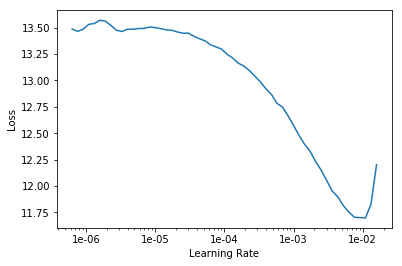

In [146]:
learn.recorder.plot(skip_end=15)

In [147]:
lr = 3e-3